In [1]:
import itertools
from pomps.policy_scope import PolicyComponent, MixedPolicyScope
from pomis.scm import *
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.gp_fcm import *
from pomps.controllers import *
import pyro
import torch
from tqdm.auto import tqdm
import pyro.distributions as dist
from pomps.fcm import *
import seaborn as sns
import matplotlib.pyplot as plt
# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM

In [2]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1: pyro.sample("C", dist.Normal(U1, 0.1)), 'C'),
                             Functor(lambda C, U1: pyro.sample("X1", dist.Normal(U1+C, 0.1)), 'X1'),
                             Functor(lambda C, X1, U2: pyro.sample("X2", dist.Normal(C+X1, torch.abs(U2))), 'X2'),
                             Functor(lambda U2, X2, C: pyro.sample("X2", 
                                        dist.Normal(torch.cos(C-X2)+U2/100, 0.01)), "Y")}, sampler_over)

# def model(count):
#     with pyro.plate("samples", count):
#         age = pyro.sample("age", dist.Uniform(55, 76))
#         bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

#         aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
#         statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

#         aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
#         statin = pyro.sample("statin", dist.Bernoulli(statin_p))

#         cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
#         cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

#         mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
#         y = pyro.sample("y", dist.Normal(mean, 0.4))
#     return y
# scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
# aspirin_graph = scm.induced_graph()
# ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
#                       contextual_variables={"age", "bmi"}, target='y')
# ccg = MPSDAGController.simplify(ccg)

In [3]:
sum([fcm.sample()["Y"] for i in range(1000)])/1000

tensor(0.4237)

In [4]:
aspirin_graph = fcm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"X1", "X2"}, 
                      contextual_variables={"C", "X1"}, target='Y')
ccg = MPSDAGController.simplify(ccg)
space = [RealDomain("X1", -2, 2), RealDomain("X2", -2, 2), RealDomain("C", -2, 2)]
gpf = GPFunctorFactory(space)

In [5]:
ccg.interventional_variables, ccg.contextual_variables, ccg.uc_variables

({'X1', 'X2'}, {'C', 'X1'}, {'U1', 'U2'})

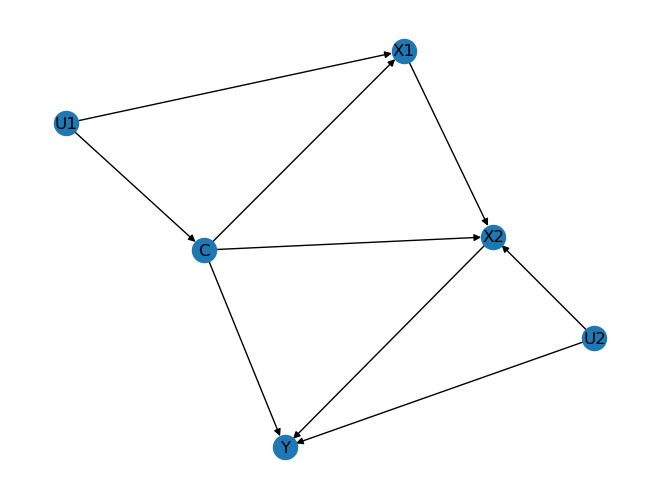

In [6]:
nx.draw(ccg, with_labels=True)

In [7]:
interventional_set = ccg.interventional_variables
contextual_set = ccg.contextual_variables

In [8]:
def all_combs(base, start=0):
    return list(itertools.chain(*[itertools.combinations(base, i) for i in range(start, len(base)+1)]))

def inter_cont_pair_gen(interventional_set, contextual_set):
    inter_segment = []
    context_space = all_combs(contextual_set)
    for inter in interventional_set:
        inter_segment += [[(inter, i) for i in context_space]]
    
    iam = all_combs(inter_segment)
    return itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], [])

def mpss(pair_gen):
    for mps_row in pair_gen:
        yield MixedPolicyScope({PolicyComponent(target, set(context))  for target, context in mps_row })

In [9]:
a = {1}
b = a
b = b | {2}

In [10]:
a, b

({1}, {1, 2})

In [11]:
mpses = list(mpss(inter_cont_pair_gen(interventional_set, contextual_set)))
print(len(mpses))
graph_under_mps = [(MPSDAGController.graph_under_mps(mps, ccg), mps) for mps in mpses]
print(len(graph_under_mps))

graph_under_mps = [(g[0][0], g[1]) for g in graph_under_mps if g[0][1]]
print(len(graph_under_mps))

graph_under_mps = [g for g in graph_under_mps if MPSReductor.action_relevance_check(g[1], g[0]) and MPSReductor.context_relevance_check(g[1], g[0])]
print(len(graph_under_mps))
graph_under_mps = [g for g in graph_under_mps if not MPSReductor.sufficiently_not_pomp(g[1], g[0])]
print(len(graph_under_mps))

25
25
15
set()
call
set()
call
{'C'}
call
set()
call
set()
call
{'X1'} set()
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
{'X2', 'X1'} {'X2', 'X1'}
set()
call
set()
call
{'C'}
call
{'X1', 'C'} {'C'}
{'X2', 'X1', 'C'} {'X1', 'C'}
{'X2', 'X1', 'C'} {'X1', 'C'}
{'X2', 'X1', 'C'} {'X2', 'X1', 'C'}
{'X2', 'X1', 'C'} {'X2', 'X1', 'C'}
{'C'}
call
{'X1', 'C'} {'C'}
{'X2', 'X1', 'C'} {'X1', 'C'}
{'X2', 'X1', 'C'} {'X1', 'C'}
{'X2', 'X1', 'C'} {'X2', 'X1', 'C'}
{'X2', 'X1', 'C'} {'X2', 'X1', 'C'}
7
set()
call
{'X2'} set()
{'X2'} {'X2'}
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}
set()
call
{'X1'} set()
{'X1'} {'X1'}
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
3


In [12]:
is_single_gp = True

In [13]:
del  graph_under_mps[0]

In [14]:
graph_under_mps

[(<pomps.contextual_graphs.ContextualCausalGraph at 0x19d9019f1c0>,
  <X2, {'C'}>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x19d9019f340>,
  <X1, {'C'}>)]

In [15]:
pomps_active = {}
for idx, (graph, mps) in enumerate(graph_under_mps):
    if is_single_gp:
        policy = PolicyFCM.mps_to_single_gp(mps, gpf)
    else:
        policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
    fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)
    pomps_active[idx] = (fcm_m, list(policy)[0], mps)

[{'C'}]
[{'C'}]


In [16]:
# graph, mps = graph_under_mps[-1]
# nx.draw(graph, with_labels=True)
# is_single_gp = True
# if is_single_gp:
#     policy = PolicyFCM.mps_to_single_gp(mps, gpf)
# else:
#     policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
# fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)

In [17]:
 def not_dominated(a, b):
        return (np.asarray(a) <= b).any()

In [18]:
X = np.random.randn(1000,2)
def not_dominated(a, b):
    return (np.asarray(a) >= b).any()
    
def pareto_optimals(X):
    from scipy.spatial.distance import cdist

    X = cdist(X, X, metric=not_dominated).astype(np.bool)
    non_dominated = np.where(X.all(axis=1))[0]
    return non_dominated

pareto_optimals(X)

array([ 24, 118, 184, 275, 358, 403, 492, 535, 595, 690], dtype=int64)

In [19]:
from collections import defaultdict

In [25]:
list(pomps_active.values())[0][-1]

<X2, {'C'}>

In [22]:
[v for _, _, v in (pomps_active.values())]

[<X2, {'C'}>, <X1, {'C'}>]

In [20]:
results = defaultdict(lambda: [])
for i in tqdm(range(500)):
    print("-"*50)
    trial_index = None
    try:
        trial_index = [idx for idx, (f, p, _) in enumerate(pomps_active.values()) if p.acq_vals is None][0]
        print("None detected")
    except IndexError as _:
        fold = np.row_stack([p.acq_vals for f, p, _ in pomps_active.values()])
        print("Folds", fold)
        optimals = pareto_optimals(fold)
        print("Optimals", optimals)
        trial_index = np.random.choice(optimals)
#     trial_index=0
    results['trial_id'].append(trial_index)
    
    fcm_m, policy, mps = pomps_active[trial_index]
    if is_single_gp:
            print("Policy for", policy.variable, policy.arguments)

    print("Trial index", trial_index)
    smp = fcm_m.sample(necessary_context=policy.arguments)
    print(smp)

    print("Acq vals", policy.acq_vals)
    for arg in mps.contextual_variables:
        results[f"arg_{arg}"].append(torch.tensor([smp[arg]]).item())
    for var in mps.interventional_variables:
        results[f"int_{var}"].append(torch.tensor([smp[var]]).item())
    y = smp[graph.target]
    y = torch.tensor([y])
    
    results['Y'].append(y.item())

    if is_single_gp:
        policy.functional.observe(-y)
    else:
        for p in policy:
            p.functional.observe(-y)


  0%|          | 0/500 [00:00<?, ?it/s]

--------------------------------------------------
None detected
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5773)} {'U1': tensor(0.5413), 'U2': tensor(-0.6343), 'C': tensor(0.5773)} {'C'} {'C'} X2
{'C': tensor(0.5773), 'X2': -5.0, 'X1': tensor(1.1690), 'Y': tensor(0.7711)}
Acq vals None
--------------------------------------------------
None detected
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5188)} {'U1': tensor(0.3714), 'U2': tensor(0.6501), 'C': tensor(0.5188)} {'C'} {'C'} X2
{'C': tensor(0.5188), 'X2': 0.0, 'X1': tensor(0.8286), 'Y': tensor(0.8594)}
Acq vals None
--------------------------------------------------
None detected
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.8887)} {'U1': tensor(-0.8552), 'U2': tensor(0.5833), 'C': tensor(-0.8887)} {'C'} {'C'} X2
{'C': tensor(-0.8887), 'X2': 2.5, 'X1': tensor(-1.6820), 'Y': tensor(-0.9618)}
Acq vals None
--------------------------------------------------
None detected
Policy for X2 {'C'}
T

{'C': tensor(-0.3878), 'X2': -0.5913478835347479, 'X1': tensor(-0.6946), 'Y': tensor(0.9620)}
Acq vals [[ 2.86418009 -2.53253818 -1.25957286]]
--------------------------------------------------
Folds [[  2.86418009  -2.53253818  -1.25957286]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.4531)} {'U1': tensor(0.6187), 'U2': tensor(-0.9294), 'C': tensor(0.4531)} {'C'} {'C'} X2
fitting GP
{'C': tensor(0.4531), 'X2': 0.5369043448287776, 'X1': tensor(1.1647), 'Y': tensor(0.9819)}
Acq vals [[ 2.06172991 -1.56193066 -0.31628978]]
--------------------------------------------------
Folds [[  2.06172991  -1.56193066  -0.31628978]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.4954)} {'U1': tensor(0.5948), 'U2': tensor(-0.0536), 'C': tensor(0.4954)} {'C'} {'C'} X2
fitting GP
{'C': tensor(0.4954), 'X2': 0.26983348005970553, 'X1': tensor(1.1237), 'Y': tensor(0.9866

{'C': tensor(0.2867), 'X2': 0.27346952875949804, 'X1': tensor(0.5978), 'Y': tensor(0.9982)}
Acq vals [[ 1.45460558 -1.96987844 -0.05121658]]
--------------------------------------------------
Folds [[  1.45460558  -1.96987844  -0.05121658]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2356)} {'U1': tensor(-0.1950), 'U2': tensor(0.0671), 'C': tensor(-0.2356)} {'C'} {'C'} X2
fitting GP
{'C': tensor(-0.2356), 'X2': -0.19611566707388095, 'X1': tensor(-0.4446), 'Y': tensor(0.9765)}
Acq vals [[ 1.25423503 -1.54295623 -0.00451013]]
--------------------------------------------------
Folds [[ 1.25423503e+00 -1.54295623e+00 -4.51012701e-03]
 [ 8.83997560e-01 -1.77674885e+01 -1.50260944e+01]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.6271)} {'U1': tensor(0.6019), 'U2': tensor(-0.3415), 'C': tensor(0.6271)} {'C'} {'C'} X2
fitting GP
{'C': tensor(0.6271), 'X2': 0.5137043574418125, 'X1': tensor(1.2488

{'C': tensor(-0.2409), 'X2': 4.997486127794739, 'X1': tensor(-0.6975), 'Y': tensor(0.5240)}
Acq vals [[ 1.61374867 -6.81003046 -4.92087507]]
--------------------------------------------------
Folds [[  1.61374867  -6.81003046  -4.92087507]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5747)} {'U1': tensor(0.5943), 'U2': tensor(-0.5858), 'C': tensor(0.5747)} {'C'} {'C'} X2
fitting GP
{'C': tensor(0.5747), 'X2': 0.7562835916485781, 'X1': tensor(1.0795), 'Y': tensor(0.9851)}
Acq vals [[ 1.54335999 -2.57689357 -0.45911276]]
--------------------------------------------------
Folds [[  1.54335999  -2.57689357  -0.45911276]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(-1.0084)} {'U1': tensor(-0.7422), 'U2': tensor(0.5325), 'C': tensor(-1.0084)} {'C'} {'C'} X2
fitting GP
{'C': tensor(-1.0084), 'X2': 4.999739484311207, 'X1': tensor(-1.7167), 'Y': tensor(0.9629

{'C': tensor(-0.3319), 'X2': -0.32526267073288645, 'X1': tensor(-0.6871), 'Y': tensor(0.9998)}
Acq vals [[ 1.24788117 -1.9698981  -0.0682203 ]]
--------------------------------------------------
Folds [[  1.24788117  -1.9698981   -0.0682203 ]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2257)} {'U1': tensor(-0.2296), 'U2': tensor(0.0411), 'C': tensor(-0.2257)} {'C'} {'C'} X2
fitting GP
{'C': tensor(-0.2257), 'X2': -0.13030004686843594, 'X1': tensor(-0.6534), 'Y': tensor(1.0171)}
Acq vals [[ 1.37419212 -4.17022276 -1.24657464]]
--------------------------------------------------
Folds [[  1.37419212  -4.17022276  -1.24657464]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.3856)} {'U1': tensor(0.2659), 'U2': tensor(-0.3121), 'C': tensor(0.3856)} {'C'} {'C'} X2
fitting GP
{'C': tensor(0.3856), 'X2': 0.317756535509398, 'X1': tensor(0.5944), 'Y': tensor(0

{'C': tensor(0.5394), 'X2': 0.5362290243394057, 'X1': tensor(1.2270), 'Y': tensor(0.9781)}
Acq vals [[ 1.19122684 -1.5922631  -0.00865487]]
--------------------------------------------------
Folds [[ 1.19122684e+00 -1.59226310e+00 -8.65486544e-03]
 [ 8.83997560e-01 -1.77674885e+01 -1.50260944e+01]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.0750)} {'U1': tensor(0.0489), 'U2': tensor(0.0679), 'C': tensor(0.0750)} {'C'} {'C'} X2
fitting GP
{'C': tensor(0.0750), 'X2': 0.15694753815837903, 'X1': tensor(0.2203), 'Y': tensor(1.0052)}
Acq vals [[ 1.48885953 -2.54772449 -0.29702181]]
--------------------------------------------------
Folds [[  1.48885953  -2.54772449  -0.29702181]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.3483)} {'U1': tensor(-0.2074), 'U2': tensor(-0.2232), 'C': tensor(-0.3483)} {'C'} {'C'} X2
fitting GP
{'C': tensor(-0.3483), 'X2': -0.36921321311978916, 'X1': tensor(-0.5393

{'C': tensor(0.5953), 'X2': 0.7083047712231393, 'X1': tensor(0.8383), 'Y': tensor(1.0279)}
Acq vals [[ 9.44744229e-01 -9.77487803e-01 -2.04464828e-04]]
--------------------------------------------------
Folds [[ 9.44744229e-01 -9.77487803e-01 -2.04464828e-04]
 [ 8.83997560e-01 -1.77674885e+01 -1.50260944e+01]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.3223)} {'U1': tensor(0.3207), 'U2': tensor(-0.9949), 'C': tensor(0.3223)} {'C'} {'C'} X2
fitting GP
{'C': tensor(0.3223), 'X2': 0.3773812395138408, 'X1': tensor(0.7548), 'Y': tensor(0.9871)}
Acq vals [[ 1.48774767 -2.0487175  -0.15082204]]
--------------------------------------------------
Folds [[  1.48774767  -2.0487175   -0.15082204]
 [  0.88399756 -17.76748848 -15.02609444]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5179)} {'U1': tensor(0.6810), 'U2': tensor(0.7743), 'C': tensor(0.5179)} {'C'} {'C'} X2
fitting GP
{'C': tensor(0.5179), 'X2': 0.6856865645377865, 'X1': tensor(1.

{'C': tensor(0.0403), 'X2': 0.02144289516009812, 'X1': -2.3353915256683253, 'Y': tensor(0.9982)}
Acq vals [[ 2.78403449 -1.64979768 -0.92784607]]
--------------------------------------------------
Folds [[ 1.61433578 -3.48117542 -0.93334788]
 [ 2.78403449 -1.64979768 -0.92784607]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.1083)} {'U1': tensor(-0.0478), 'U2': tensor(0.0571), 'C': tensor(-0.1083)} {'C'} {'C'} X2
buffer {}
{'C': tensor(-0.1083)} {'U1': tensor(-0.0478), 'U2': tensor(0.0571), 'C': tensor(-0.1083), 'X2': -0.018254636006140173} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.1083), 'X2': -0.018254636006140173, 'X1': -3.216568976407957, 'Y': tensor(0.9956)}
Acq vals [[ 2.7040801  -1.54651749 -0.76985914]]
--------------------------------------------------
Folds [[ 1.60036123 -2.32427216 -0.24068049]
 [ 2.7040801  -1.54651749 -0.76985914]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.5045)} {'U1': tensor(-0.5918), 'U2': ten

buffer {}
{'C': tensor(-0.8134)} {'U1': tensor(-0.9578), 'U2': tensor(-0.9911), 'C': tensor(-0.8134), 'X2': -0.7857273172099222} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8134), 'X2': -0.7857273172099222, 'X1': 4.704935568747914, 'Y': tensor(0.9896)}
Acq vals [[ 1.32828236 -1.32680523 -0.05546415]]
--------------------------------------------------
Folds [[ 1.07679892e+00 -9.12529528e-01 -1.62614699e-04]
 [ 1.32828236e+00 -1.32680523e+00 -5.54641522e-02]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.8768)} {'U1': tensor(0.9572), 'U2': tensor(0.0322), 'C': tensor(0.8768)} {'C'} {'C'} X2
buffer {}
{'C': tensor(0.8768)} {'U1': tensor(0.9572), 'U2': tensor(0.0322), 'C': tensor(0.8768), 'X2': 0.8875196719587103} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.8768), 'X2': 0.8875196719587103, 'X1': -2.6546584416830856, 'Y': tensor(1.0096)}
Acq vals [[ 1.62474716 -2.80429935 -0.79278171]]
--------------------------------------------------
Folds [[ 1.03937697e+00 -9.30672

buffer {}
{'C': tensor(-0.7098)} {'U1': tensor(-0.4870), 'U2': tensor(0.7162), 'C': tensor(-0.7098), 'X2': -0.6617223586947281} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.7098), 'X2': -0.6617223586947281, 'X1': -4.208152157528535, 'Y': tensor(1.0124)}
Acq vals [[ 1.14863920e+00 -8.84030223e-01 -9.43586056e-05]]
--------------------------------------------------
Folds [[ 1.55379415e+00 -1.89619648e+00 -1.21533275e-01]
 [ 1.14863920e+00 -8.84030223e-01 -9.43586056e-05]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.0316)} {'U1': tensor(0.0110), 'U2': tensor(-0.8355), 'C': tensor(0.0316)} {'C'} {'C'} X2
buffer {}
{'C': tensor(0.0316)} {'U1': tensor(0.0110), 'U2': tensor(-0.8355), 'C': tensor(0.0316), 'X2': 0.005133828600803705} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.0316), 'X2': 0.005133828600803705, 'X1': 3.568498090023982, 'Y': tensor(0.9931)}
Acq vals [[ 1.82559311 -6.48303986 -4.64088774]]
--------------------------------------------------
Folds [[ 1.58313

buffer {}
{'C': tensor(-0.2448)} {'U1': tensor(-0.3681), 'U2': tensor(-0.3149), 'C': tensor(-0.2448), 'X2': -0.16665319488475125} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.2448), 'X2': -0.16665319488475125, 'X1': -4.097037996670915, 'Y': tensor(1.0002)}
Acq vals [[ 1.07721305 -1.44220519 -0.01901963]]
--------------------------------------------------
Folds [[ 1.19631648e+00 -1.06135130e+00 -7.57384929e-04]
 [ 1.07721305e+00 -1.44220519e+00 -1.90196279e-02]]
Optimals [0]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7245)} {'U1': tensor(0.7584), 'U2': tensor(-0.5213), 'C': tensor(0.7245)} {'C'} {'C'} X2
{'C': tensor(0.7245), 'X2': 0.6392433855229228, 'X1': tensor(1.4904), 'Y': tensor(0.9964)}
Acq vals [[ 1.56071615 -2.34235382 -0.30158332]]
--------------------------------------------------
Folds [[ 1.56071615 -2.34235382 -0.30158332]
 [ 1.07721305 -1.44220519 -0.01901963]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.1030)} {'U1': tensor(-0.1

buffer {}
{'C': tensor(-0.3198)} {'U1': tensor(-0.3413), 'U2': tensor(0.0532), 'C': tensor(-0.3198), 'X2': -0.3749887900627288} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.3198), 'X2': -0.3749887900627288, 'X1': -1.8634657859802246, 'Y': tensor(1.0014)}
Acq vals [[ 2.02694821 -0.64884245 -0.11252413]]
--------------------------------------------------
Folds [[ 1.38575363 -2.32498646 -0.27022699]
 [ 2.02694821 -0.64884245 -0.11252413]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.7494)} {'U1': tensor(-0.7394), 'U2': tensor(-0.7853), 'C': tensor(-0.7494)} {'C'} {'C'} X2
buffer {}
{'C': tensor(-0.7494)} {'U1': tensor(-0.7394), 'U2': tensor(-0.7853), 'C': tensor(-0.7494), 'X2': -0.6294328058870425} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.7494), 'X2': -0.6294328058870425, 'X1': -1.3569800503998994, 'Y': tensor(0.9891)}
Acq vals [[ 2.67022371 -0.8172043  -0.17537275]]
--------------------------------------------------
Folds [[ 1.51500833 -2.68513918 -0.52554649]
 

buffer {}
{'C': tensor(-0.6373)} {'U1': tensor(-0.6902), 'U2': tensor(0.3338), 'C': tensor(-0.6373), 'X2': -0.6024057939203189} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.6373), 'X2': -0.6024057939203189, 'X1': -4.883059665436409, 'Y': tensor(1.0092)}
Acq vals [[ 3.42294884 -1.9284451  -1.07417035]]
--------------------------------------------------
Folds [[ 1.39415431e+00 -1.05517030e+00 -1.54507253e-03]
 [ 3.42294884e+00 -1.92844510e+00 -1.07417035e+00]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.7957)} {'U1': tensor(0.7571), 'U2': tensor(0.0109), 'C': tensor(0.7957)} {'C'} {'C'} X2
buffer {}
{'C': tensor(0.7957)} {'U1': tensor(0.7571), 'U2': tensor(0.0109), 'C': tensor(0.7957), 'X2': 0.8989608012312746} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7957), 'X2': 0.8989608012312746, 'X1': -3.5911910248838446, 'Y': tensor(0.9920)}
Acq vals [[ 1.92807615 -0.31114    -0.00300788]]
--------------------------------------------------
Folds [[ 1.63166809e+00 -3.88375

buffer {}
{'C': tensor(0.1309)} {'U1': tensor(-0.0562), 'U2': tensor(-0.4454), 'C': tensor(0.1309), 'X2': 0.16474239329035578} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.1309), 'X2': 0.16474239329035578, 'X1': 4.1960975077976865, 'Y': tensor(0.9924)}
Acq vals [[ 1.8155812  -0.53389871 -0.01320978]]
--------------------------------------------------
Folds [[ 9.52620387e-01 -6.16677403e-01 -1.31130309e-06]
 [ 1.81558120e+00 -5.33898711e-01 -1.32097825e-02]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.2810)} {'U1': tensor(0.3646), 'U2': tensor(-0.4959), 'C': tensor(0.2810)} {'C'} {'C'} X2
{'C': tensor(0.2810), 'X2': 0.23719905396290014, 'X1': tensor(0.7152), 'Y': tensor(0.9864)}
Acq vals [[ 1.27801871e+00 -9.96531188e-01 -7.65378063e-04]]
--------------------------------------------------
Folds [[ 1.27801871e+00 -9.96531188e-01 -7.65378063e-04]
 [ 1.81558120e+00 -5.33898711e-01 -1.32097825e-02]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': t

buffer {}
{'C': tensor(-0.5042)} {'U1': tensor(-0.4581), 'U2': tensor(0.5428), 'C': tensor(-0.5042), 'X2': -0.5329268950708668} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.5042), 'X2': -0.5329268950708668, 'X1': -3.7617207179326173, 'Y': tensor(1.0124)}
Acq vals [[ 1.84502149 -0.29764763 -0.00241266]]
--------------------------------------------------
Folds [[ 1.39475656 -1.30443645 -0.01502104]
 [ 1.84502149 -0.29764763 -0.00241266]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.7487)} {'U1': tensor(0.7763), 'U2': tensor(0.1334), 'C': tensor(0.7487)} {'C'} {'C'} X2
buffer {}
{'C': tensor(0.7487)} {'U1': tensor(0.7763), 'U2': tensor(0.1334), 'C': tensor(0.7487), 'X2': 0.8099069413355636} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7487), 'X2': 0.8099069413355636, 'X1': -4.884467261605571, 'Y': tensor(1.0053)}
Acq vals [[ 2.41884422 -0.15879878 -0.00532307]]
--------------------------------------------------
Folds [[ 1.45791471 -1.45577717 -0.03406845]
 [ 2.41884422

buffer {}
{'C': tensor(-0.0714)} {'U1': tensor(-0.0683), 'U2': tensor(0.0346), 'C': tensor(-0.0714), 'X2': -0.001092747557669485} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.0714), 'X2': -0.001092747557669485, 'X1': -1.8636145516293046, 'Y': tensor(0.9900)}
Acq vals [[ 2.87489653  0.1186289  -0.01250785]]
--------------------------------------------------
Folds [[ 1.5342834  -5.43538761 -2.53168082]
 [ 2.87489653  0.1186289  -0.01250785]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.5124)} {'U1': tensor(-0.5900), 'U2': tensor(-0.0310), 'C': tensor(-0.5124)} {'C'} {'C'} X2
buffer {}
{'C': tensor(-0.5124)} {'U1': tensor(-0.5900), 'U2': tensor(-0.0310), 'C': tensor(-0.5124), 'X2': -0.556880869601381} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.5124), 'X2': -0.556880869601381, 'X1': 4.8984528019855755, 'Y': tensor(0.9951)}
Acq vals [[ 3.7111783  -0.42299834 -0.25320724]]
--------------------------------------------------
Folds [[ 1.47257483e+00 -1.05198133e+00 -2.65

buffer {}
{'C': tensor(0.8261)} {'U1': tensor(0.9624), 'U2': tensor(0.7776), 'C': tensor(0.8261), 'X2': 0.8492686548622501} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.8261), 'X2': 0.8492686548622501, 'X1': -4.9968737503436484, 'Y': tensor(1.0109)}
Acq vals [[ 3.88018799 -2.28414106 -1.56652951]]
--------------------------------------------------
Folds [[ 1.45151973 -1.55250216 -0.042852  ]
 [ 3.88018799 -2.28414106 -1.56652951]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(1.0206)} {'U1': tensor(0.9411), 'U2': tensor(-0.7522), 'C': tensor(1.0206)} {'C'} {'C'} X2
buffer {}
{'C': tensor(1.0206)} {'U1': tensor(0.9411), 'U2': tensor(-0.7522), 'C': tensor(1.0206), 'X2': 1.1154356534850391} {'C'} {'C'} X1
fitting GP
{'C': tensor(1.0206), 'X2': 1.1154356534850391, 'X1': -4.997253345404543, 'Y': tensor(0.9913)}
Acq vals [[ 1.69523919 -0.10177032 -0.00581492]]
--------------------------------------------------
Folds [[ 1.51377273 -1.54083693 -0.13103235]
 [ 1.69523919 -

buffer {}
{'C': tensor(-0.0682)} {'U1': tensor(-0.0077), 'U2': tensor(-0.8407), 'C': tensor(-0.0682), 'X2': -0.058329312163742396} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.0682), 'X2': -0.058329312163742396, 'X1': 0.7115973785730949, 'Y': tensor(0.9965)}
Acq vals [[ 4.88143015 -2.48544478 -1.91319728]]
--------------------------------------------------
Folds [[ 9.27649260e-01 -8.03823531e-01 -8.19597481e-05]
 [ 4.88143015e+00 -2.48544478e+00 -1.91319728e+00]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.7613)} {'U1': tensor(0.7924), 'U2': tensor(-0.3049), 'C': tensor(0.7613)} {'C'} {'C'} X2
buffer {}
{'C': tensor(0.7613)} {'U1': tensor(0.7924), 'U2': tensor(-0.3049), 'C': tensor(0.7613), 'X2': 0.9025862820678058} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7613), 'X2': 0.9025862820678058, 'X1': -4.098531172129344, 'Y': tensor(0.9829)}
Acq vals [[ 3.49729347 -0.40840346 -0.10953435]]
--------------------------------------------------
Folds [[ 1.69751096 -6.485

{'C': tensor(0.2475), 'X2': 0.2292821215013497, 'X1': 4.598123395959003, 'Y': tensor(0.9879)}
Acq vals [[ 4.76864052 -1.21746147 -0.85839206]]
--------------------------------------------------
Folds [[ 1.62995505 -4.27705526 -1.57913935]
 [ 4.76864052 -1.21746147 -0.85839206]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.4673)} {'U1': tensor(-0.4463), 'U2': tensor(0.0530), 'C': tensor(-0.4673)} {'C'} {'C'} X2
buffer {}
{'C': tensor(-0.4673)} {'U1': tensor(-0.4463), 'U2': tensor(0.0530), 'C': tensor(-0.4673), 'X2': -0.4530582029676593} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.4673), 'X2': -0.4530582029676593, 'X1': -1.5588769563345752, 'Y': tensor(1.0132)}
Acq vals [[ 5.06915092 -1.22442079 -0.85391068]]
--------------------------------------------------
Folds [[ 1.32234037e+00 -5.55525780e-01 -1.07288417e-06]
 [ 5.06915092e+00 -1.22442079e+00 -8.53910685e-01]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.4568)} {'U1': tensor(0.

{'C': tensor(-0.9655), 'X2': 1.5242142654248079, 'X1': -4.999997368076427, 'Y': tensor(-0.7871)}
Acq vals [[ 5.63436651 -2.17800355 -1.66413891]]
--------------------------------------------------
Folds [[  2.14222002 -10.80017281  -9.30316353]
 [  5.63436651  -2.17800355  -1.66413891]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.2674)} {'U1': tensor(-0.2797), 'U2': tensor(-0.6765), 'C': tensor(-0.2674)} {'C'} {'C'} X2
buffer {}
{'C': tensor(-0.2674)} {'U1': tensor(-0.2797), 'U2': tensor(-0.6765), 'C': tensor(-0.2674), 'X2': -0.10405601279098456} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.2674), 'X2': -0.10405601279098456, 'X1': 1.0641635968024508, 'Y': tensor(0.9663)}
Acq vals [[ 5.52551746 -0.99046075 -0.76752794]]
--------------------------------------------------
Folds [[ 1.43566144 -1.53601408 -0.03784962]
 [ 5.52551746 -0.99046075 -0.76752794]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.8623)} {'U1': tensor(0.9531), 'U2':

{'C': tensor(-0.1542), 'X2': -0.07747480272214607, 'X1': 3.816244617029353, 'Y': tensor(0.9822)}
Acq vals [[ 4.96837521 -0.47891986 -0.41398609]]
--------------------------------------------------
Folds [[ 1.43981051e+00 -1.23534441e+00 -4.29167040e-03]
 [ 4.96837521e+00 -4.78919864e-01 -4.13986087e-01]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.8050)} {'U1': tensor(-0.6974), 'U2': tensor(-0.7821), 'C': tensor(-0.8050)} {'C'} {'C'} X2
buffer {}
{'C': tensor(-0.8050)} {'U1': tensor(-0.6974), 'U2': tensor(-0.7821), 'C': tensor(-0.8050), 'X2': -0.6354400498923523} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8050), 'X2': -0.6354400498923523, 'X1': -0.9274182233168835, 'Y': tensor(0.9964)}
Acq vals [[ 4.23934507 -0.45011407 -0.2881296 ]]
--------------------------------------------------
Folds [[ 1.51364851 -2.15847325 -0.29010591]
 [ 4.23934507 -0.45011407 -0.2881296 ]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.8120)} {'U1': ten

buffer {}
{'C': tensor(0.2261)} {'U1': tensor(0.1903), 'U2': tensor(-0.9939), 'C': tensor(0.2261), 'X2': 0.18780337793839663} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.2261), 'X2': 0.18780337793839663, 'X1': 0.39870684965254943, 'Y': tensor(0.9905)}
Acq vals [[ 5.3552413  -0.95800793 -0.73474813]]
--------------------------------------------------
Folds [[ 1.36319256e+00 -1.11983812e+00 -2.47366959e-03]
 [ 5.35524130e+00 -9.58007932e-01 -7.34748125e-01]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.7237)} {'U1': tensor(-0.7762), 'U2': tensor(-0.4053), 'C': tensor(-0.7237)} {'C'} {'C'} X2
buffer {}
{'C': tensor(-0.7237)} {'U1': tensor(-0.7762), 'U2': tensor(-0.4053), 'C': tensor(-0.7237), 'X2': -0.610196833847064} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.7237), 'X2': -0.610196833847064, 'X1': 2.1459217071533203, 'Y': tensor(0.9976)}
Acq vals [[ 5.84006405 -1.52737606 -1.12385571]]
--------------------------------------------------
Folds [[ 1.40371227e+00 -7

buffer {}
{'C': tensor(0.5107)} {'U1': tensor(0.4092), 'U2': tensor(-0.4226), 'C': tensor(0.5107), 'X2': 0.4604995674197823} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.5107), 'X2': 0.4604995674197823, 'X1': -4.349254209308931, 'Y': tensor(0.9847)}
Acq vals [[ 3.02738023 -0.40425909 -0.09631059]]
--------------------------------------------------
Folds [[ 1.58272505 -2.43597507 -0.34867254]
 [ 3.02738023 -0.40425909 -0.09631059]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.9815)} {'U1': tensor(0.9124), 'U2': tensor(-0.9581), 'C': tensor(0.9815)} {'C'} {'C'} X2
buffer {}
{'C': tensor(0.9815)} {'U1': tensor(0.9124), 'U2': tensor(-0.9581), 'C': tensor(0.9815), 'X2': 0.47564650332674446} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.9815), 'X2': 0.47564650332674446, 'X1': -3.767808190398178, 'Y': tensor(0.8622)}
Acq vals [[ 5.55588961 -1.53728819 -1.12036538]]
--------------------------------------------------
Folds [[ 1.78815114 -6.01661253 -3.93012929]
 [ 5.55588961 -

buffer {}
{'C': tensor(0.1218)} {'U1': tensor(0.1453), 'U2': tensor(0.8898), 'C': tensor(0.1218), 'X2': 0.14464228000965795} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.1218), 'X2': 0.14464228000965795, 'X1': -3.605248574442977, 'Y': tensor(0.9991)}
Acq vals [[ 5.56540585 -1.70734525 -1.23881018]]
--------------------------------------------------
Folds [[ 1.34306693e+00 -1.10047102e+00 -2.03040591e-03]
 [ 5.56540585e+00 -1.70734525e+00 -1.23881018e+00]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.1101)} {'U1': tensor(-0.1107), 'U2': tensor(-0.2285), 'C': tensor(-0.1101)} {'C'} {'C'} X2
buffer {}
{'C': tensor(-0.1101)} {'U1': tensor(-0.1107), 'U2': tensor(-0.2285), 'C': tensor(-0.1101), 'X2': -0.07313483865926179} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.1101), 'X2': -0.07313483865926179, 'X1': -3.514265271389296, 'Y': tensor(0.9977)}
Acq vals [[ 5.33900976 -1.5491035  -1.10846889]]
--------------------------------------------------
Folds [[ 1.24000275e+00 

{'C': tensor(0.4554), 'X2': 0.3358325958251953, 'X1': tensor(0.6853), 'Y': tensor(0.9633)}
Acq vals [[ 1.26644266 -1.24173903 -0.0088747 ]]
--------------------------------------------------
Folds [[ 1.26644266 -1.24173903 -0.0088747 ]
 [ 6.60376692 -1.92529166 -1.41004801]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.5789)} {'U1': tensor(-0.5218), 'U2': tensor(-0.6989), 'C': tensor(-0.5789)} {'C'} {'C'} X2
fitting GP
{'C': tensor(-0.5789), 'X2': -0.6494094207089319, 'X1': tensor(-1.1019), 'Y': tensor(0.9941)}
Acq vals [[ 1.57243919 -3.00078988 -0.76888752]]
--------------------------------------------------
Folds [[ 1.57243919 -3.00078988 -0.76888752]
 [ 6.60376692 -1.92529166 -1.41004801]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.3076)} {'U1': tensor(0.4274), 'U2': tensor(-0.5449), 'C': tensor(0.3076)} {'C'} {'C'} X2
fitting GP
buffer {}
{'C': tensor(0.3076)} {'U1': tensor(0.4274), 'U2': tensor(-0.5449), 'C': tensor(0.30

buffer {}
{'C': tensor(0.8172)} {'U1': tensor(0.7377), 'U2': tensor(-0.4879), 'C': tensor(0.8172), 'X2': 0.8262036142525369} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.8172), 'X2': 0.8262036142525369, 'X1': 2.8636834713637613, 'Y': tensor(0.9936)}
Acq vals [[ 4.78457403 -1.03555703 -0.75937998]]
--------------------------------------------------
Folds [[ 1.52802444 -1.56302404 -0.05456266]
 [ 4.78457403 -1.03555703 -0.75937998]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.5383)} {'U1': tensor(0.4583), 'U2': tensor(-0.3764), 'C': tensor(0.5383)} {'C'} {'C'} X2
buffer {}
{'C': tensor(0.5383)} {'U1': tensor(0.4583), 'U2': tensor(-0.3764), 'C': tensor(0.5383), 'X2': 0.7792564371684462} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.5383), 'X2': 0.7792564371684462, 'X1': -4.053694690645251, 'Y': tensor(0.9644)}
Acq vals [[ 2.41129017  0.35562834 -0.00264673]]
--------------------------------------------------
Folds [[ 8.67104590e-01 -5.58468580e-01 -5.74605292e-05]
 [ 

buffer {}
{'C': tensor(0.4125)} {'U1': tensor(0.3087), 'U2': tensor(-0.9630), 'C': tensor(0.4125), 'X2': 0.2968691617514523} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.4125), 'X2': 0.2968691617514523, 'X1': 2.9176550679969937, 'Y': tensor(0.9881)}
Acq vals [[ 5.45188522 -3.13869786 -2.38933659]]
--------------------------------------------------
Folds [[ 1.06854844e+00 -8.28586042e-01 -4.99850255e-04]
 [ 5.45188522e+00 -3.13869786e+00 -2.38933659e+00]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5284)} {'U1': tensor(0.3341), 'U2': tensor(-0.6954), 'C': tensor(0.5284)} {'C'} {'C'} X2
{'C': tensor(0.5284), 'X2': 0.6479276069470188, 'X1': tensor(0.8130), 'Y': tensor(0.9818)}
Acq vals [[ 1.55174685 -2.0818038  -0.2328376 ]]
--------------------------------------------------
Folds [[ 1.55174685 -2.0818038  -0.2328376 ]
 [ 5.45188522 -3.13869786 -2.38933659]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.6953)} {'U1': tensor(-0.6464), 

buffer {}
{'C': tensor(-0.5545)} {'U1': tensor(-0.5348), 'U2': tensor(-0.7031), 'C': tensor(-0.5545), 'X2': -0.5792634010627505} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.5545), 'X2': -0.5792634010627505, 'X1': -1.0352538546287193, 'Y': tensor(0.9829)}
Acq vals [[ 5.37975597 -2.20538235 -1.58486688]]
--------------------------------------------------
Folds [[ 1.23490644e+00 -5.87472200e-01 -4.86385725e-05]
 [ 5.37975597e+00 -2.20538235e+00 -1.58486688e+00]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2032)} {'U1': tensor(-0.2661), 'U2': tensor(-0.2329), 'C': tensor(-0.2032)} {'C'} {'C'} X2
{'C': tensor(-0.2032), 'X2': -0.10921709523011697, 'X1': tensor(-0.4393), 'Y': tensor(0.9969)}
Acq vals [[ 1.41665435e+00 -6.65376842e-01 -8.32115475e-05]]
--------------------------------------------------
Folds [[ 1.41665435e+00 -6.65376842e-01 -8.32115475e-05]
 [ 5.37975597e+00 -2.20538235e+00 -1.58486688e+00]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer 

{'C': tensor(0.5431), 'X2': 0.5751424247997949, 'X1': tensor(0.8128), 'Y': tensor(1.0005)}
Acq vals [[ 1.40567553 -1.23303413 -0.01922115]]
--------------------------------------------------
Folds [[ 1.40567553 -1.23303413 -0.01922115]
 [ 5.09719515 -2.74168324 -2.04501057]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(1.0733)} {'U1': tensor(0.9802), 'U2': tensor(-0.0161), 'C': tensor(1.0733)} {'C'} {'C'} X2
fitting GP
buffer {}
{'C': tensor(1.0733)} {'U1': tensor(0.9802), 'U2': tensor(-0.0161), 'C': tensor(1.0733), 'X2': 0.984600400506396} {'C'} {'C'} X1
fitting GP
{'C': tensor(1.0733), 'X2': 0.984600400506396, 'X1': -0.4092029581812703, 'Y': tensor(0.9994)}
Acq vals [[ 4.92823648 -2.28073812 -1.67537403]]
--------------------------------------------------
Folds [[ 1.06443024e+00 -7.81359255e-01 -2.08332436e-03]
 [ 4.92823648e+00 -2.28073812e+00 -1.67537403e+00]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.9010)} {'U1': tensor(

buffer {}
{'C': tensor(0.5049)} {'U1': tensor(0.3672), 'U2': tensor(0.9485), 'C': tensor(0.5049), 'X2': 0.5167703723819385} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.5049), 'X2': 0.5167703723819385, 'X1': 0.9232719976877033, 'Y': tensor(1.0028)}
Acq vals [[ 5.19071531 -1.68447316 -1.20427823]]
--------------------------------------------------
Folds [[ 8.14874470e-01 -8.14194024e-01 -9.36231052e-04]
 [ 5.19071531e+00 -1.68447316e+00 -1.20427823e+00]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.8226)} {'U1': tensor(0.7586), 'U2': tensor(0.5055), 'C': tensor(0.8226)} {'C'} {'C'} X2
buffer {}
{'C': tensor(0.8226)} {'U1': tensor(0.7586), 'U2': tensor(0.5055), 'C': tensor(0.8226), 'X2': 0.7841482367632273} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.8226), 'X2': 0.7841482367632273, 'X1': -4.030272435218394, 'Y': tensor(1.0112)}
Acq vals [[ 5.21156836 -2.38560152 -1.76136398]]
--------------------------------------------------
Folds [[ 1.84758282 -4.27339029 -1.7521

{'C': tensor(-0.8199), 'X2': -0.635730012507535, 'X1': tensor(-1.5247), 'Y': tensor(0.9931)}
Acq vals [[ 1.73571873 -4.76731014 -2.23813486]]
--------------------------------------------------
Folds [[ 1.73571873 -4.76731014 -2.23813486]
 [ 5.34861755 -2.57792068 -1.92554939]]
Optimals [1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.3214)} {'U1': tensor(-0.3620), 'U2': tensor(-0.1433), 'C': tensor(-0.3214)} {'C'} {'C'} X2
fitting GP
buffer {}
{'C': tensor(-0.3214)} {'U1': tensor(-0.3620), 'U2': tensor(-0.1433), 'C': tensor(-0.3214), 'X2': -0.306351744103703} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.3214), 'X2': -0.306351744103703, 'X1': -1.167013957169827, 'Y': tensor(0.9932)}
Acq vals [[ 4.80241251 -1.99786818 -1.45114446]]
--------------------------------------------------
Folds [[ 1.59407258 -1.14889121 -0.01566565]
 [ 4.80241251 -1.99786818 -1.45114446]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.2038)} {'U1': tensor(0.1988), 'U2': te

{'C': tensor(0.7017), 'X2': 0.709395434497103, 'X1': tensor(1.3891), 'Y': tensor(0.9943)}
Acq vals [[ 1.00665247e+00 -3.60292017e-01 -2.80142217e-06]]
--------------------------------------------------
Folds [[ 1.00665247e+00 -3.60292017e-01 -2.80142217e-06]
 [ 5.10793924e+00 -2.16137934e+00 -1.58222854e+00]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.6852)} {'U1': tensor(-0.6944), 'U2': tensor(0.6853), 'C': tensor(-0.6852)} {'C'} {'C'} X2
fitting GP
buffer {}
{'C': tensor(-0.6852)} {'U1': tensor(-0.6944), 'U2': tensor(0.6853), 'C': tensor(-0.6852), 'X2': -0.6382243934594388} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.6852), 'X2': -0.6382243934594388, 'X1': -2.4736226953225815, 'Y': tensor(0.9998)}
Acq vals [[ 5.24356604 -2.38984108 -1.7620492 ]]
--------------------------------------------------
Folds [[ 1.94573855e+00 -7.67328262e-01 -1.10389106e-03]
 [ 5.24356604e+00 -2.38984108e+00 -1.76204920e+00]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 1
buf

In [27]:
dict(results)

{'trial_id': [0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1

In [28]:
import pickle 
with open('temp_res.bin', "wb") as fd: 
    pickle.dump(dict(results), fd)

In [36]:
for k,v in results.items():
    print(k, len(v))

trial_id 500
arg_C 500
int_X2 248
Y 500
int_X1 252


In [44]:
pomps_active[0]

(<pomps.fcm.FunctionalCausalModel at 0x253871144f0>,
 <X2, {'C'}>)

In [48]:
 np.array(results["int_X2"])

array([-5.00000000e+00,  0.00000000e+00,  2.50000000e+00,  2.88187599e+00,
       -2.76688766e+00,  3.72562385e+00, -4.99735069e+00, -4.99917173e+00,
       -2.35988975e-01,  3.68504733e-01,  8.36614668e-01, -4.81353045e+00,
        3.33927691e-01, -5.80706224e-02, -5.91347873e-01,  5.36904335e-01,
        2.69833475e-01, -3.67526054e-01, -3.14037770e-01,  4.98794842e+00,
       -8.31889212e-01,  7.19358921e-01, -1.28295219e+00,  4.52464700e-01,
       -1.54751912e-01, -1.38887537e+00, -7.71355629e-01, -2.10756049e-01,
       -3.73264432e-01,  3.83386277e-02, -1.73288081e-02,  2.51333117e-01,
        2.73469537e-01, -1.96115673e-01,  5.13704360e-01, -4.44872618e+00,
       -9.30718184e-01,  1.60902369e+00,  1.47449344e-01, -3.17411184e+00,
        2.72266954e-01,  6.17187878e-04,  5.50645106e-02,  4.99877644e+00,
        4.61303234e+00,  3.61435980e-01,  5.00145018e-01,  1.08852375e+00,
       -5.09934723e-02, -6.52949512e-01,  4.99748611e+00,  7.56283581e-01,
        4.99973965e+00, -

In [53]:
np.array(results["arg_C"])[np.array(results["trial_id"])== 0].shape

(248,)

In [52]:
 np.array(results["int_X2"]).shape

(248,)

In [57]:
1/len(np.array(results["arg_C"])[np.array(results["trial_id"])== 0])

0.004032258064516129

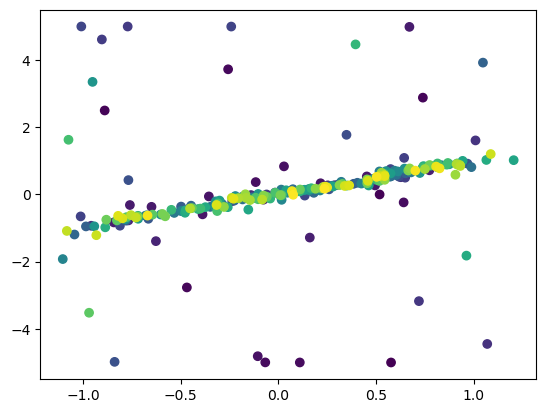

In [58]:
plt.scatter(np.array(results["arg_C"])[np.array(results["trial_id"])== 0], np.array(results["int_X2"]), c=np.arange(0,1,1/len(np.array(results["arg_C"])[np.array(results["trial_id"])== 0])))

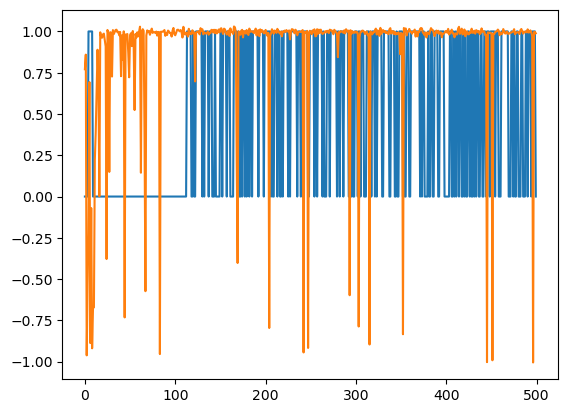

In [29]:
plt.plot(results["trial_id"][:len(results["Y"])])
plt.plot(results["Y"])


<AxesSubplot:xlabel='trial_id', ylabel='Y'>

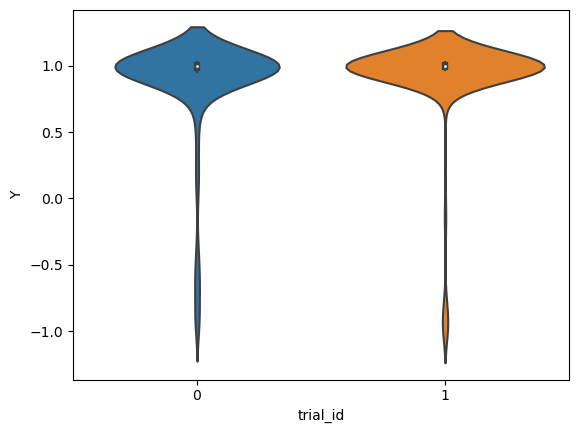

In [30]:
# plt.plot(results["trial_id"])
df = pd.DataFrame({"trial_id": results["trial_id"][:len(results["Y"])], "Y": results["Y"]})
sns.violinplot(data=df, x="trial_id", y="Y")
# df["trial_id"].plot()

In [31]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

ValueError: All arrays must be of the same length

<AxesSubplot:>

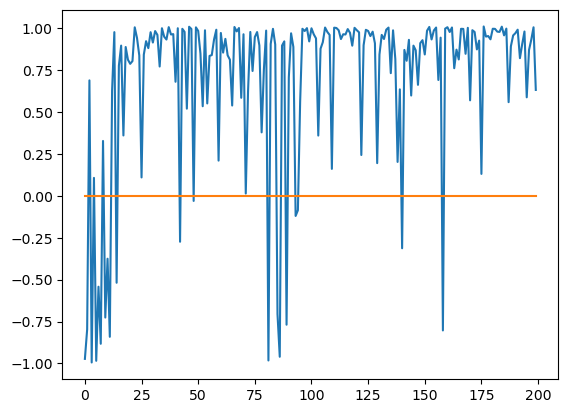

In [27]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

<AxesSubplot:>

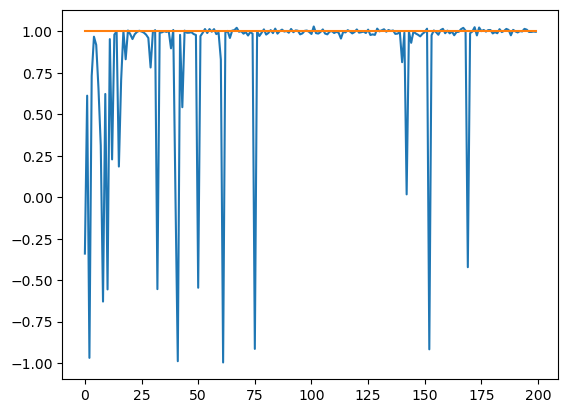

In [25]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

In [16]:
fcm_m.functors['X1'].functional.optimizer.best_x

AttributeError: 'function' object has no attribute 'optimizer'

In [24]:
sum([fcm_m.sample()["Y"] for i in range(1000)])/1000

buffer {}
{'C': tensor(0.3349)} {'U1': tensor(0.3719), 'U2': tensor(0.7512), 'C': tensor(0.3349)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7771)} {'U1': tensor(0.7568), 'U2': tensor(0.8532), 'C': tensor(0.7771)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0657)} {'U1': tensor(-0.0564), 'U2': tensor(0.7644), 'C': tensor(-0.0657)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4529)} {'U1': tensor(-0.5128), 'U2': tensor(-0.6284), 'C': tensor(-0.4529)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5106)} {'U1': tensor(-0.4139), 'U2': tensor(0.7545), 'C': tensor(-0.5106)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8877)} {'U1': tensor(-0.7459), 'U2': tensor(0.3416), 'C': tensor(-0.8877)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1970)} {'U1': tensor(-0.4769), 'U2': tensor(0.4977), 'C': tensor(-0.1970)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4069)} {'U1': tensor(0.1989), 'U2': tensor(0.1013), 'C': tensor(0.4069)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8208)} {'U1': tensor(0.8586), 'U2': tensor(0.4828), 'C'

buffer {}
{'C': tensor(-0.0826)} {'U1': tensor(-0.1725), 'U2': tensor(-0.2601), 'C': tensor(-0.0826)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7305)} {'U1': tensor(-0.7769), 'U2': tensor(0.8565), 'C': tensor(-0.7305)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2101)} {'U1': tensor(0.1865), 'U2': tensor(0.7967), 'C': tensor(0.2101)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8682)} {'U1': tensor(-0.8046), 'U2': tensor(0.8763), 'C': tensor(-0.8682)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8163)} {'U1': tensor(0.7040), 'U2': tensor(0.7685), 'C': tensor(0.8163)} {'C'} {'C'} X1
buffer {}
{'C': tensor(1.1254)} {'U1': tensor(0.9448), 'U2': tensor(-0.6513), 'C': tensor(1.1254)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5405)} {'U1': tensor(0.3392), 'U2': tensor(-0.0293), 'C': tensor(0.5405)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0810)} {'U1': tensor(0.1673), 'U2': tensor(-0.9943), 'C': tensor(0.0810)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4630)} {'U1': tensor(-0.3076), 'U2': tensor(0.3345), 'C':

buffer {}
{'C': tensor(-0.8831)} {'U1': tensor(-0.9199), 'U2': tensor(0.2879), 'C': tensor(-0.8831)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8514)} {'U1': tensor(0.9622), 'U2': tensor(-0.9442), 'C': tensor(0.8514)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4965)} {'U1': tensor(0.3669), 'U2': tensor(-0.6430), 'C': tensor(0.4965)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5541)} {'U1': tensor(0.4135), 'U2': tensor(-0.5419), 'C': tensor(0.5541)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0034)} {'U1': tensor(-0.0057), 'U2': tensor(-0.2678), 'C': tensor(0.0034)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1918)} {'U1': tensor(0.2384), 'U2': tensor(-0.2486), 'C': tensor(0.1918)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7709)} {'U1': tensor(-0.7085), 'U2': tensor(-0.3898), 'C': tensor(-0.7709)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9593)} {'U1': tensor(-0.9224), 'U2': tensor(-0.1760), 'C': tensor(-0.9593)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8826)} {'U1': tensor(-0.7230), 'U2': tensor(0.1477), 

buffer {}
{'C': tensor(0.5760)} {'U1': tensor(0.5169), 'U2': tensor(0.5109), 'C': tensor(0.5760)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8842)} {'U1': tensor(0.8401), 'U2': tensor(-0.7519), 'C': tensor(0.8842)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.9440)} {'U1': tensor(0.8113), 'U2': tensor(0.2589), 'C': tensor(0.9440)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6413)} {'U1': tensor(0.4306), 'U2': tensor(-0.7571), 'C': tensor(0.6413)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3826)} {'U1': tensor(0.4504), 'U2': tensor(0.8981), 'C': tensor(0.3826)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7998)} {'U1': tensor(-0.8659), 'U2': tensor(-0.1180), 'C': tensor(-0.7998)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5297)} {'U1': tensor(0.5546), 'U2': tensor(0.5995), 'C': tensor(0.5297)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0143)} {'U1': tensor(-0.0347), 'U2': tensor(0.8202), 'C': tensor(-0.0143)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4345)} {'U1': tensor(0.4569), 'U2': tensor(0.7620), 'C': tenso

buffer {}
{'C': tensor(-0.1189)} {'U1': tensor(-0.0938), 'U2': tensor(0.0194), 'C': tensor(-0.1189)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.6137)} {'U1': tensor(-0.6591), 'U2': tensor(-0.2989), 'C': tensor(-0.6137)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0524)} {'U1': tensor(-0.0660), 'U2': tensor(-0.5848), 'C': tensor(-0.0524)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5177)} {'U1': tensor(-0.6928), 'U2': tensor(-0.7024), 'C': tensor(-0.5177)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5313)} {'U1': tensor(-0.5620), 'U2': tensor(-0.8155), 'C': tensor(-0.5313)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1454)} {'U1': tensor(-0.0175), 'U2': tensor(0.0422), 'C': tensor(0.1454)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5630)} {'U1': tensor(-0.6514), 'U2': tensor(-0.4816), 'C': tensor(-0.5630)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3591)} {'U1': tensor(0.3934), 'U2': tensor(-0.8009), 'C': tensor(0.3591)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4661)} {'U1': tensor(-0.5258), 'U2': tensor(-

buffer {}
{'C': tensor(0.9043)} {'U1': tensor(0.8370), 'U2': tensor(0.2800), 'C': tensor(0.9043)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4979)} {'U1': tensor(-0.5933), 'U2': tensor(-0.6975), 'C': tensor(-0.4979)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1955)} {'U1': tensor(0.3159), 'U2': tensor(0.1914), 'C': tensor(0.1955)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8228)} {'U1': tensor(0.8365), 'U2': tensor(-0.8311), 'C': tensor(0.8228)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1452)} {'U1': tensor(0.0165), 'U2': tensor(0.4228), 'C': tensor(0.1452)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6527)} {'U1': tensor(0.6728), 'U2': tensor(-0.0269), 'C': tensor(0.6527)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7418)} {'U1': tensor(0.8572), 'U2': tensor(0.5438), 'C': tensor(0.7418)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.1149)} {'U1': tensor(-0.9314), 'U2': tensor(-0.2623), 'C': tensor(-1.1149)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3576)} {'U1': tensor(-0.4068), 'U2': tensor(0.4516), 'C': te

buffer {}
{'C': tensor(-0.2605)} {'U1': tensor(-0.1974), 'U2': tensor(0.6820), 'C': tensor(-0.2605)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7080)} {'U1': tensor(-0.6539), 'U2': tensor(-0.5800), 'C': tensor(-0.7080)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1962)} {'U1': tensor(-0.1209), 'U2': tensor(-0.6859), 'C': tensor(-0.1962)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3317)} {'U1': tensor(-0.3432), 'U2': tensor(0.9108), 'C': tensor(-0.3317)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5358)} {'U1': tensor(0.6242), 'U2': tensor(-0.2945), 'C': tensor(0.5358)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4936)} {'U1': tensor(-0.5909), 'U2': tensor(0.0204), 'C': tensor(-0.4936)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8006)} {'U1': tensor(-0.7364), 'U2': tensor(0.6268), 'C': tensor(-0.8006)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4201)} {'U1': tensor(0.4380), 'U2': tensor(-0.8074), 'C': tensor(0.4201)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3488)} {'U1': tensor(-0.4807), 'U2': tensor(0.20

buffer {}
{'C': tensor(0.8632)} {'U1': tensor(0.8400), 'U2': tensor(-0.3019), 'C': tensor(0.8632)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5471)} {'U1': tensor(0.5901), 'U2': tensor(0.4975), 'C': tensor(0.5471)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4346)} {'U1': tensor(-0.3862), 'U2': tensor(-0.3856), 'C': tensor(-0.4346)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1115)} {'U1': tensor(0.0449), 'U2': tensor(-0.0992), 'C': tensor(-0.1115)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8716)} {'U1': tensor(-0.8064), 'U2': tensor(0.1268), 'C': tensor(-0.8716)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4199)} {'U1': tensor(-0.4835), 'U2': tensor(0.9957), 'C': tensor(-0.4199)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0742)} {'U1': tensor(-0.0154), 'U2': tensor(-0.1419), 'C': tensor(-0.0742)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2648)} {'U1': tensor(0.2363), 'U2': tensor(0.5823), 'C': tensor(0.2648)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.2307)} {'U1': tensor(-0.1762), 'U2': tensor(0.2684),

buffer {}
{'C': tensor(-0.7200)} {'U1': tensor(-0.7917), 'U2': tensor(0.8466), 'C': tensor(-0.7200)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4914)} {'U1': tensor(0.5409), 'U2': tensor(-0.5575), 'C': tensor(0.4914)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3602)} {'U1': tensor(-0.4817), 'U2': tensor(0.1817), 'C': tensor(-0.3602)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8527)} {'U1': tensor(0.9669), 'U2': tensor(0.8734), 'C': tensor(0.8527)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2812)} {'U1': tensor(0.2954), 'U2': tensor(-0.5136), 'C': tensor(0.2812)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1320)} {'U1': tensor(-0.1157), 'U2': tensor(0.4703), 'C': tensor(-0.1320)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8327)} {'U1': tensor(-0.9343), 'U2': tensor(0.7960), 'C': tensor(-0.8327)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4639)} {'U1': tensor(0.4223), 'U2': tensor(0.1996), 'C': tensor(0.4639)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1517)} {'U1': tensor(0.1631), 'U2': tensor(0.7737), 'C': 

buffer {}
{'C': tensor(0.7163)} {'U1': tensor(0.7433), 'U2': tensor(0.1738), 'C': tensor(0.7163)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4338)} {'U1': tensor(0.5537), 'U2': tensor(0.4018), 'C': tensor(0.4338)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1834)} {'U1': tensor(-0.1808), 'U2': tensor(-0.4139), 'C': tensor(-0.1834)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2210)} {'U1': tensor(0.1760), 'U2': tensor(-0.3728), 'C': tensor(0.2210)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2724)} {'U1': tensor(0.1958), 'U2': tensor(-0.3086), 'C': tensor(0.2724)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0632)} {'U1': tensor(-0.0409), 'U2': tensor(-0.3894), 'C': tensor(-0.0632)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5110)} {'U1': tensor(0.6527), 'U2': tensor(-0.9544), 'C': tensor(0.5110)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1151)} {'U1': tensor(-0.0863), 'U2': tensor(0.8031), 'C': tensor(-0.1151)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.0386)} {'U1': tensor(-0.9930), 'U2': tensor(-0.3480), 'C

buffer {}
{'C': tensor(-0.6770)} {'U1': tensor(-0.7848), 'U2': tensor(0.7386), 'C': tensor(-0.6770)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2808)} {'U1': tensor(0.3138), 'U2': tensor(-0.9476), 'C': tensor(0.2808)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0668)} {'U1': tensor(0.1259), 'U2': tensor(-0.4100), 'C': tensor(0.0668)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3069)} {'U1': tensor(-0.1921), 'U2': tensor(0.5152), 'C': tensor(-0.3069)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4478)} {'U1': tensor(0.3611), 'U2': tensor(0.3289), 'C': tensor(0.4478)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.6927)} {'U1': tensor(-0.8606), 'U2': tensor(-0.6609), 'C': tensor(-0.6927)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1773)} {'U1': tensor(0.2386), 'U2': tensor(-0.4545), 'C': tensor(0.1773)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1060)} {'U1': tensor(-0.2210), 'U2': tensor(-0.7924), 'C': tensor(-0.1060)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0553)} {'U1': tensor(-0.1733), 'U2': tensor(0.2183), 

buffer {}
{'C': tensor(-0.3746)} {'U1': tensor(-0.4899), 'U2': tensor(0.5303), 'C': tensor(-0.3746)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1851)} {'U1': tensor(0.1951), 'U2': tensor(0.6746), 'C': tensor(0.1851)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5059)} {'U1': tensor(0.5822), 'U2': tensor(-0.6482), 'C': tensor(0.5059)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8479)} {'U1': tensor(-0.7988), 'U2': tensor(-0.7120), 'C': tensor(-0.8479)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4502)} {'U1': tensor(0.4586), 'U2': tensor(0.4371), 'C': tensor(0.4502)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3096)} {'U1': tensor(-0.4339), 'U2': tensor(0.3793), 'C': tensor(-0.3096)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.0461)} {'U1': tensor(-0.9740), 'U2': tensor(0.9017), 'C': tensor(-1.0461)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3604)} {'U1': tensor(0.1088), 'U2': tensor(0.0483), 'C': tensor(0.3604)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4458)} {'U1': tensor(-0.4618), 'U2': tensor(0.5717), 'C'

buffer {}
{'C': tensor(0.9711)} {'U1': tensor(0.9691), 'U2': tensor(-0.2759), 'C': tensor(0.9711)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3080)} {'U1': tensor(-0.2169), 'U2': tensor(-0.0886), 'C': tensor(-0.3080)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1525)} {'U1': tensor(-0.0877), 'U2': tensor(-0.4516), 'C': tensor(-0.1525)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5952)} {'U1': tensor(-0.4424), 'U2': tensor(0.3671), 'C': tensor(-0.5952)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.2978)} {'U1': tensor(-0.4826), 'U2': tensor(0.6547), 'C': tensor(-0.2978)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9360)} {'U1': tensor(-0.9212), 'U2': tensor(-0.2856), 'C': tensor(-0.9360)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7938)} {'U1': tensor(-0.8422), 'U2': tensor(-0.9802), 'C': tensor(-0.7938)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7554)} {'U1': tensor(0.7457), 'U2': tensor(-0.3465), 'C': tensor(0.7554)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2671)} {'U1': tensor(0.3315), 'U2': tensor(-0.6

buffer {}
{'C': tensor(-0.6224)} {'U1': tensor(-0.6409), 'U2': tensor(-0.1234), 'C': tensor(-0.6224)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5573)} {'U1': tensor(-0.6019), 'U2': tensor(0.5680), 'C': tensor(-0.5573)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7920)} {'U1': tensor(-0.7927), 'U2': tensor(-0.7087), 'C': tensor(-0.7920)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1150)} {'U1': tensor(0.1502), 'U2': tensor(0.8838), 'C': tensor(0.1150)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1073)} {'U1': tensor(-0.0371), 'U2': tensor(0.3344), 'C': tensor(0.1073)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4883)} {'U1': tensor(0.5051), 'U2': tensor(0.9682), 'C': tensor(0.4883)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9867)} {'U1': tensor(-0.9137), 'U2': tensor(-0.5154), 'C': tensor(-0.9867)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5191)} {'U1': tensor(0.3431), 'U2': tensor(-0.6637), 'C': tensor(0.5191)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6618)} {'U1': tensor(0.4974), 'U2': tensor(0.2298), 'C

tensor(0.8081)

In [18]:
g = graph_under_mps[-2]
print(g[1])
MPSReductor.sufficiently_not_pomp(g[1], g[0])

<X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}


False

In [27]:
g[0].uc_variables

{'U1'}

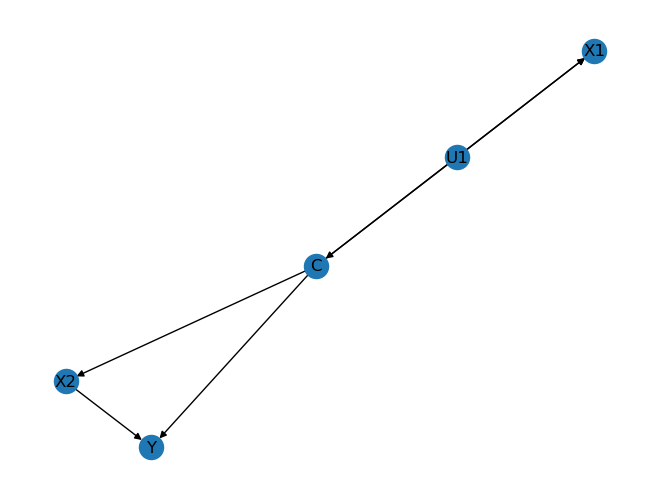

In [28]:
nx.draw(g[0], with_labels=True)

In [15]:
for idx, g in enumerate(graph_under_mps):
    print(idx, g[1])
    MPSReductor.sufficiently_not_pomp(g[1], g[0])

0 
1 <X2, set()>
set()
call
{'X2'} set()
{'X2'} {'X2'}
set()
call
{'X2'} set()
{'X2'} {'X2'}
2 <X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}
3 <X2, {'X1'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
4 <X1, set()>
set()
call
{'X1'} set()
{'X1'} {'X1'}
5 <X1, {'C'}>
6 <X2, {'X1'}>	<X1, {'C'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}


In [10]:
mps = MixedPolicyScope(dict())
MPSDAGController.graph_under_mps(mps, ccg), mps

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7f8e610e3130>, True), )

In [8]:
g = graph_under_mps[0]
MPSReductor.sufficiently_not_pomp(g[1], g[0][0])

False

In [9]:
g

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fed29561520>, True),
 <statin, set()>)

In [16]:
graph_under_mps[1]

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fcde0cb9580>, True),
 <aspirin, {'age'}>)

In [18]:
MPSReductor.action_relevance_check(graph_under_mps[0][1], graph_under_mps[0][0][0])

True

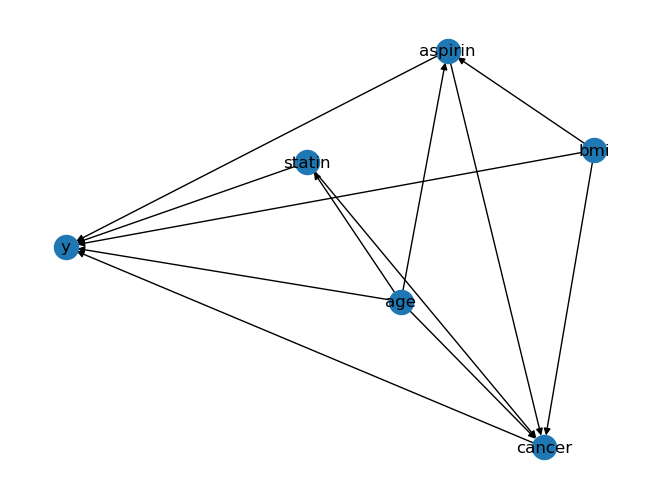

In [36]:
nx.draw(graph_under_mps[i][0], with_labels=True)

In [96]:
inter_segment = []
for inter in interventional_set:
    inter_segment += [[(inter, i) for i in contexts]]

In [104]:
iam = all_combs(inter_segment)
list(itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], []))

[(),
 (('X1', ()),),
 (('X1', ('C2',)),),
 (('X1', ('C1',)),),
 (('X1', ('C2', 'C1')),),
 (('X2', ()),),
 (('X2', ('C2',)),),
 (('X2', ('C1',)),),
 (('X2', ('C2', 'C1')),),
 (('X1', ()), ('X2', ())),
 (('X1', ()), ('X2', ('C2',))),
 (('X1', ()), ('X2', ('C1',))),
 (('X1', ()), ('X2', ('C2', 'C1'))),
 (('X1', ('C2',)), ('X2', ())),
 (('X1', ('C2',)), ('X2', ('C2',))),
 (('X1', ('C2',)), ('X2', ('C1',))),
 (('X1', ('C2',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C1',)), ('X2', ())),
 (('X1', ('C1',)), ('X2', ('C2',))),
 (('X1', ('C1',)), ('X2', ('C1',))),
 (('X1', ('C1',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C2', 'C1')), ('X2', ())),
 (('X1', ('C2', 'C1')), ('X2', ('C2',))),
 (('X1', ('C2', 'C1')), ('X2', ('C1',))),
 (('X1', ('C2', 'C1')), ('X2', ('C2', 'C1')))]

In [100]:
list(itertools.product(interventional_set, contexts))

[('X1', ()),
 ('X1', ('C2',)),
 ('X1', ('C1',)),
 ('X1', ('C2', 'C1')),
 ('X2', ()),
 ('X2', ('C2',)),
 ('X2', ('C1',)),
 ('X2', ('C2', 'C1'))]